# 用lenet5识别mnist
lenet5，所以conv size就是5?不是，算第五个版本吧也许，lenet-1也是5*5的核

## lenet-5的原始论文和现在的代码并不一样。
输入32*32,比mnist的28*28大，目的是把输入放的更居中一些。不过本例还是直接用了28*28。
如果想用32*32,直接resize输入成32*32还是用crop之类的把28*28图片放到32*32的背景中间？实验怎么设计？
如果本例是32*32,是不是相对原论文各层都相应有变化？不然FC怎么连上？连的上，FC的weights入反正都是flatten动态得到的，出的设置可以设置成不变。而且，本例没有用120-84-10的设置，而是512-512-10.


## 先说一下典型lenet-5的实现和各层参数计算
应该是论文的实现，和现在的tensorflow实现并不一样。
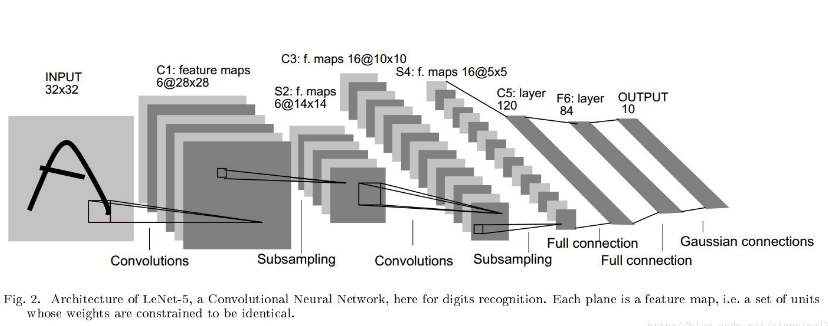


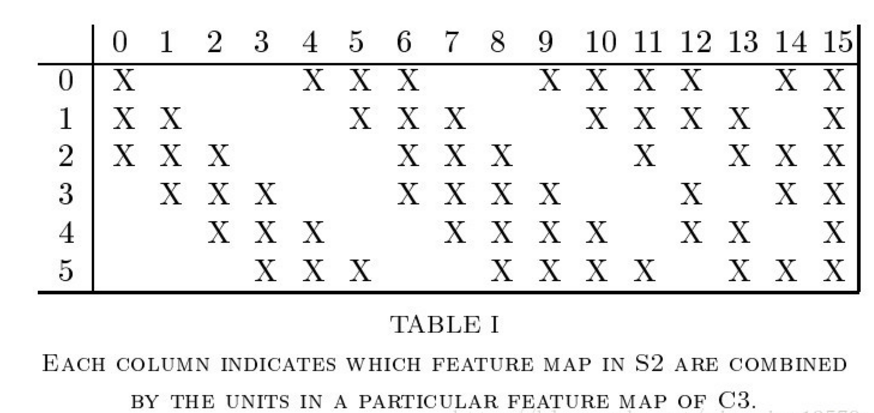

C1:
6个feature maps，卷积核5*5,有偏置，总参数6*(5*5+1)=156
总的连接数：因为输出是28*28,也就是滑窗会有28*28次，每一次应该是5*5个连接,偏置也算一个连接？到底是原图到窗口的连接，还是窗口到输出的连接？原图到窗口不用连接？前者吧？窗口到输出的话，连接还乘什么窗口数？我觉得是25*28*28*6,有个博客说是26*28*28*6，那个偏置算一个连接吗？好像算，假设他就是个输入特征，和5*5个输入特征一样，那就是占用一个连接！！另一个角度，想一下，每个窗口应该用的bias是否本应不同，是，那么，占一个连接。
S2:
下采样，输入是14*14*6,这个其实不用参数吧。连接的话，也是按窗口算？一个窗口2*2,不应该啊，原封不动，不需要参数就没有连接吧。那个博客说4个输入相加乘以一个可训练系数，还加一个可训练偏置，结果还要sigmoid？感觉这不太像啊，现在都是一个maxpooling，论文版本和现在实现的区别？卷积可以实现下采样，max_pooling也可以，这个倒是没争议。

如果也当作类似卷积，和他的描述有点冲突，可能语言不严谨吧，如果类似卷积，一个感受野是2*2,不重叠，输出是6*14*14,那么连接数是6*14*14*（2*2+1）=5880,
而他的说法是“S2层每个单元的4个输入相加，乘以一个可训练参数，再加上一个可训练偏置。”我理解是总共1+1个参数，而不是4+1。

不过区别于conv层，输入应该不跨层，每一层都独立计算，14*14个窗口，2*2+1个连接，但是6层都不同，所以最后乘以6.

C3:
刚才C1的输入是1层，现在是6层变16层
按常规推测：
参数：16*（5*5+1）*6或者16*（5*5）*6 +1,因为记得有示意图，卷积核面对多层input，只有一个bias。
连接数：16*（5*5+1）*（10*10）*6

但是，这是lenet，早期的网络，如表1,连接很特殊，不是全连接
C3层有1516个可训练参数((25*3+1)*6+(25*4+1)*9+(25*6+1))和151600个连接。

其他层不说了，暂时参考不上，总之，和现在的实现方法有区别。

## 现代lenet-5的TF实现，参数数量计算

现代的lenet-5,pooling层应该是不用参数的，max-pooling，卷积层也是全连接的卷积。

对比优缺点的话，max-pooling少了参数和连接数，但是没有前者的边缘模糊？
而全连接的卷积，参数和连接数会更多

C1层：
参数：6*（5*5+1）
连接:(5*5+1)*28*28*6=122304 

C3层：
参数：16*（5*5*6+1），或者，换个更像TF中变量的写法：6*5*5*16+16
这个规则根据下图不同输入层共享一个bias，TF的实际实现，需要定义的bias也是如此。TF中也可以直观打印出对应的shape去观察。

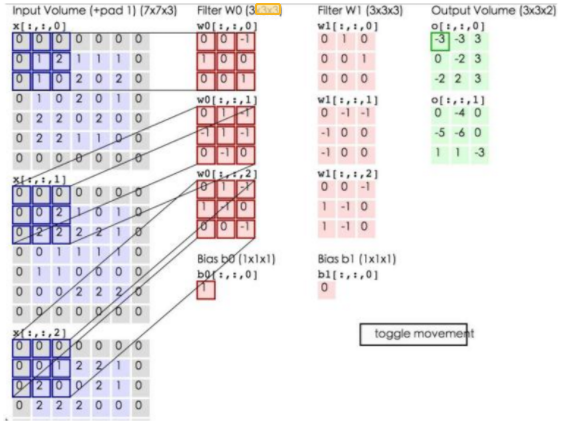

In [1]:
import tensorflow as tf


In [2]:
IMAGE_SIZE = 28#不是32*32的版本，简化了。
INPUT_CHANNELS = 1
CONV1_SIZE = 5
CONV1_KERNEL_NUM = 32
CONV2_SIZE = 5
CONV2_KERNEL_NUM = 64
FC_SIZE = 512
OUTPUT_SIZE = 10

In [3]:
#接口定义
def get_weight(shape, regular_scaler = None):
    w = tf.Variable(tf.truncated_normal(shape, stddev=0.1))
    if regular_scaler:
        tf.add_to_collection('regularization', tf.contrib.layers.l2_regularizer(regular_scaler)(w))
    return w
def get_bias(shape):
    b = tf.Variable(tf.zeros(shape))
    return b    
def conv2d(x,w):
    return tf.nn.conv2d(x, w, strides=[1,1,1,1], padding='SAME')
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize= [1,2,2,1],strides=[1,2,2,1], padding = 'SAME')

In [4]:
def net(x, is_train, regular_scaler):
    conv1_w = get_weight(shape = [CONV1_SIZE, CONV1_SIZE, INPUT_CHANNELS, CONV1_KERNEL_NUM],regular_scaler = regular_scaler)
    conv1_b = get_bias(shape = [CONV1_KERNEL_NUM])
    conv1 = conv2d(x, conv1_w)
    relu1 = tf.nn.relu(conv1 + conv1_b)#和tf.nn.bias_add(conv1,conv1_b)没差吧。
#     relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_b))#和tf.nn.bias_add(conv1,conv1_b)没差吧。
    pool1 = max_pool_2x2(relu1)
    
    conv2_w = get_weight(shape = [CONV2_SIZE, CONV2_SIZE, CONV1_KERNEL_NUM, CONV2_KERNEL_NUM],regular_scaler = regular_scaler)
    conv2_b = get_bias(shape = [CONV2_KERNEL_NUM])
    conv2 = conv2d(pool1, conv2_w)
    relu2 = tf.nn.relu(conv2 + conv2_b)
#     relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_b))
    pool2 = max_pool_2x2(relu2)
    
    #先拿到尺寸
    dims = pool2.get_shape().as_list()#
#     pool2_flatten = tf.reshape(pool2, [dims[0], dims[1] * dims[2] * dims[3]])
    pool2_flatten = tf.reshape(pool2, [-1, dims[1] * dims[2] * dims[3]])#一样的效果
    
    #fc1_w = get_weight(shape = [CONV2_KERNEL_NUM, FC_SIZE])错误写法，注意入口shape，应该是前一层计算的
    fc1_w = get_weight(shape = [dims[1] * dims[2] * dims[3], FC_SIZE])
    fc1_b = get_bias(shape = [FC_SIZE])
    fc1 = tf.matmul(pool2_flatten, fc1_w) + fc1_b
    fc1_relu = tf.nn.relu(fc1)
    
    if is_train:
        fc1_relu = tf.nn.dropout(fc1_relu,0.5)
    fc2_w = get_weight(shape = [FC_SIZE, OUTPUT_SIZE])
    fc2_b = get_bias(shape = [OUTPUT_SIZE])
    fc2 = tf.matmul(fc1_relu, fc2_w) + fc2_b#输出层了，不用再relu了。
    y = fc2
    
    return y

In [5]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import os
import numpy as np

In [6]:
BATCH_SIZE = 100
LEARNING_RATE_BASE = 0.005
LEARNING_RATE_DECAY = 0.99
REGULAR_SCALE = 0.0001
STEPS = 50000
MOVING_AVERAGE_DECAY = 0.99
MODEL_SAVE_PATH = './model_lenet5/'
MODEL_NAME='MNIST_lenet5_model'#mode name？在哪用的，就是ckpt的文件名

DATA_DIR = 'MNIST_data'

def train(mnist):
    x = tf.placeholder(tf.float32, shape = [
        BATCH_SIZE,#None一样吧
        IMAGE_SIZE,
        IMAGE_SIZE,#正方形
        INPUT_CHANNELS
    ])
    y_ = tf.placeholder(tf.float32, [None, OUTPUT_SIZE])
    y = net(x, True, REGULAR_SCALE)
    global_step = tf.Variable(0, trainable = False)
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = y, labels = tf.argmax(y_,1))#one-hot的转换
    cem = tf.reduce_mean(ce)
    loss = cem + tf.add_n(tf.get_collection('regularization'))
    
    learning_rate = tf.train.exponential_decay(LEARNING_RATE_BASE,
                                              global_step,
                                              mnist.train.num_examples / BATCH_SIZE,
                                              LEARNING_RATE_DECAY,
                                              staircase = True)
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step = global_step)
    ema = tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY, global_step)
    ema_op = ema.apply(tf.trainable_variables())
    with tf.control_dependencies([train_step, ema_op]):
        train_op = tf.no_op(name = 'train')
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        ckpt = tf.train.get_checkpoint_state(MODEL_SAVE_PATH)
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)
            
        for i in range(STEPS):
            xs,ys = mnist.train.next_batch(BATCH_SIZE)
            reshaped_xs = np.reshape(xs,(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,INPUT_CHANNELS))
            _,loss_val,step = sess.run([train_op, loss, global_step], feed_dict = {x:reshaped_xs,y_:ys})
            if i % 100 == 0:
                print('after %3d steps, loss is %g'%(step,loss_val))
                saver.save(sess, os.path.join(MODEL_SAVE_PATH, MODEL_NAME), global_step = global_step)
    


In [7]:
def main():
    mnist = input_data.read_data_sets(DATA_DIR,one_hot=True)
    train(mnist)
if __name__ == '__main__':
    main()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Restoring parameters from ./model_lenet5/MNIST_lenet5_model-50002
after 50003 steps, loss is 0.0367742


KeyboardInterrupt: 

# 其他测试

In [ ]:
不用bias_add不行？
InvalidArgumentError (see above for traceback): Assign requires shapes of both tensors to match. lhs shape= [] rhs shape= [5,5,32,64]

In [12]:
help(tf.placeholder)

Help on function placeholder in module tensorflow.python.ops.array_ops:

placeholder(dtype, shape=None, name=None)
    Inserts a placeholder for a tensor that will be always fed.
    
    **Important**: This tensor will produce an error if evaluated. Its value must
    be fed using the `feed_dict` optional argument to `Session.run()`,
    `Tensor.eval()`, or `Operation.run()`.
    
    For example:
    
    ```python
    x = tf.placeholder(tf.float32, shape=(1024, 1024))
    y = tf.matmul(x, x)
    
    with tf.Session() as sess:
      print(sess.run(y))  # ERROR: will fail because x was not fed.
    
      rand_array = np.random.rand(1024, 1024)
      print(sess.run(y, feed_dict={x: rand_array}))  # Will succeed.
    ```
    
    Args:
      dtype: The type of elements in the tensor to be fed.
      shape: The shape of the tensor to be fed (optional). If the shape is not
        specified, you can feed a tensor of any shape.
      name: A name for the operation (optional).
    
    Re

In [11]:
help(tf.nn.bias_add)#强制广播？普通的add不广播？
#这（大部分）是'tf.a d d'的特殊情况，其中'bias'仅限于一维。 
#与“tf.add”不同，“bias”的类型在两种类型都被量化的情况下可以不同于“value”。
#没有具体例子！！！！！！？？？

Help on function bias_add in module tensorflow.python.ops.nn_ops:

bias_add(value, bias, data_format=None, name=None)
    Adds `bias` to `value`.
    
    This is (mostly) a special case of `tf.add` where `bias` is restricted to 1-D.
    Broadcasting is supported, so `value` may have any number of dimensions.
    Unlike `tf.add`, the type of `bias` is allowed to differ from `value` in the
    case where both types are quantized.
    
    Args:
      value: A `Tensor` with type `float`, `double`, `int64`, `int32`, `uint8`,
        `int16`, `int8`, `complex64`, or `complex128`.
      bias: A 1-D `Tensor` with size matching the last dimension of `value`.
        Must be the same type as `value` unless `value` is a quantized type,
        in which case a different quantized type may be used.
      data_format: A string. 'NHWC' and 'NCHW' are supported.
      name: A name for the operation (optional).
    
    Returns:
      A `Tensor` with the same type as `value`.



In [3]:
help(tf.nn.max_pool)

Help on function max_pool in module tensorflow.python.ops.nn_ops:

max_pool(value, ksize, strides, padding, data_format='NHWC', name=None)
    Performs the max pooling on the input.
    
    Args:
      value: A 4-D `Tensor` with shape `[batch, height, width, channels]` and
        type `tf.float32`.
      ksize: A list of ints that has length >= 4.  The size of the window for
        each dimension of the input tensor.
      strides: A list of ints that has length >= 4.  The stride of the sliding
        window for each dimension of the input tensor.
      padding: A string, either `'VALID'` or `'SAME'`. The padding algorithm.
        See the @{tf.nn.convolution$comment here}
      data_format: A string. 'NHWC' and 'NCHW' are supported.
      name: Optional name for the operation.
    
    Returns:
      A `Tensor` with type `tf.float32`.  The max pooled output tensor.



In [23]:
#as_list()
# 不是tuple的属性。。


# pool2.get_shape(): (100, 7, 7, 64)
# type is : <class 'tensorflow.python.framework.tensor_shape.TensorShape'>
# pool2.get_shape().as_list(): [100, 7, 7, 64]
origin = (100,7,7,64)
print(origin)
# print(origin.as_list())


a = tf.Variable([[3,2],[4,2]])
print(a)
print(a.shape)
print(a.shape.as_list())
print(a.get_shape().as_list())


(100, 7, 7, 64)
<tf.Variable 'Variable_32:0' shape=(2, 2) dtype=int32_ref>
(2, 2)
[2, 2]
[2, 2]


## reshape复习
见shape_type_trans.ipynb